In [1]:
# 環境設定

import gym
from nes_py.wrappers import JoypadSpace 
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT 
import matplotlib.pyplot as plt
from skimage.transform import resize #A
import numpy as np



env = gym_super_mario_bros.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="rgb_array")    # 改
env = JoypadSpace(env, COMPLEX_MOVEMENT)

C:\Users\user\anaconda3\envs\mytorch\lib\site-packages\gym\core.py:27: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"
C:\Users\user\anaconda3\envs\mytorch\lib\site-packages\gym\envs\registration.py:556: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  f"The environment {id} is out of date. You should consider "
C:\Users\user\anaconda3\envs\mytorch\lib\site-packages\gym\envs\registration.py:628: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  f"The environment creator metadata doesn't include `render_modes`, contains: {list(env_creator.metadata.keys())}"


In [2]:
import matplotlib.pyplot as plt
from skimage.transform import resize #A
import numpy as np

def downscale_obs(obs, new_size=(42,42), to_gray=True):
    if to_gray:
        return resize(obs, new_size, anti_aliasing=True).max(axis=2) #B     # [240, 256 , 3] -> [42 , 42 , 3] -> [42 , 42]
    else: 
        return resize(obs, new_size, anti_aliasing=True)

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import deque

def prepare_state(state): #A
    return torch.from_numpy(downscale_obs(state, to_gray=True)).float().unsqueeze(dim=0)  # [240, 256, 3] -> [1, 42 , 42]


def prepare_multi_state(state1, state2): #B
    state1 = state1.clone()              # 複製
    tmp = torch.from_numpy(downscale_obs(state2, to_gray=True)).float()   # state2: [240, 256, 3] -> [42, 42]
    state1[0][0] = state1[0][1]                                           
    state1[0][1] = state1[0][2]
    state1[0][2] = tmp                                                    # state1: [1, 3 , (42 , 42) = state2]
    return state1


def prepare_initial_state(state,N=3): #C     
    state_ = torch.from_numpy(downscale_obs(state, to_gray=True)).float()     # [240, 256, 3] -> [42, 42]
    tmp = state_.repeat((N,1,1))                                              # [3, 42 , 42]
    return tmp.unsqueeze(dim=0)                                               # [1, 3 , 42 , 42]

In [4]:
def policy(qvalues, eps=None): #A
    if eps is not None:
        if torch.rand(1) < eps:
            return torch.randint(low=0,high=7,size=(1,))
        else:
            return torch.argmax(qvalues)
    else:
        return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1) #B

In [5]:
from random import shuffle
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

class ExperienceReplay:
    def __init__(self, N=500, batch_size=100):
        self.N = N #A
        self.batch_size = batch_size #B
        self.memory = [] 
        self.counter = 0
        
    def add_memory(self, state1, action, reward, state2):
        self.counter +=1 

        if self.counter % 500 == 0: #C
            self.shuffle_memory()
            
        if len(self.memory) < self.N: #D
            self.memory.append( (state1, action, reward, state2) )
        else:
            rand_index = np.random.randint(0,self.N-1)
            self.memory[rand_index] = (state1, action, reward, state2)
            

    
    def shuffle_memory(self): #E
        shuffle(self.memory)
        
    def get_batch(self): #F
        if len(self.memory) < self.batch_size:
            batch_size = len(self.memory)
        else:
            batch_size = self.batch_size
        if len(self.memory) < 1:
            print("Error: No data in memory.")
            return None
        #G
        ind = np.random.choice(np.arange(len(self.memory)),batch_size,replace=False)
        batch = [self.memory[i] for i in ind] #batch is a list of tuples
        state1_batch = torch.stack([x[0].squeeze(dim=0) for x in batch],dim=0)       # state1_batch : [N , 3 , 42 , 42]
        
        action_batch = torch.Tensor([x[1] for x in batch]).long()                    # action_batch : [N(DATA)]
        #print(action_batch.size())
        reward_batch = torch.Tensor([x[2] for x in batch])                           # reward_batch : [N(DATA)]
        
        #print(reward_batch.size())
        state2_batch = torch.stack([x[3].squeeze(dim=0) for x in batch],dim=0)       # state2_batch : [N , 3 , 42 , 42]
        return state1_batch, action_batch, reward_batch, state2_batch

In [6]:
class Phi(nn.Module): #A
    def __init__(self):
        super(Phi, self).__init__()                                              # 套用公式算feaure map 大小: int((N+2p-k)/s +1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=2, padding=1)    # [N*32*21*21]
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)   # [N*32*11*11]
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)   # [N*32*6*6]
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)   # [N*32*3*3]

    def forward(self,x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y)) #size [N , 32, 3, 3] batch, channels, 3 x 3
        y = y.flatten(start_dim=1) #size [N, 288]
        return y

class Gnet(nn.Module): #B
    def __init__(self):
        super(Gnet, self).__init__()
        self.linear1 = nn.Linear(576,256)
        self.linear2 = nn.Linear(256,12)

    def forward(self, state1,state2):
        x = torch.cat( (state1, state2) ,dim=1)                # ([N , 288], [N, 288]) - > [N, 576]
        #print(x.size())
        y = F.relu(self.linear1(x))                            # [N, 576] -> [N, 256]
        y = self.linear2(y)                                    # [N, 256] -> [N, 12]
        y = F.softmax(y,dim=1)                                 # [N, 12] -> [N, 12]
        #print(y.size())
        return y

class Fnet(nn.Module): #C                                       
    def __init__(self):
        super(Fnet, self).__init__()
        self.linear1 = nn.Linear(300,256)
        self.linear2 = nn.Linear(256,288)

    def forward(self,state,action):                               # state : [N , 288]
        action_ = torch.zeros(action.shape[0],12) #D              # action -> action_ : [N , 1(DATA)] -> [N , 12(DATA = 0)]  
        #print(action_.size())
        indices = torch.stack( (torch.arange(action.shape[0]), action.squeeze()), dim=0) # action -> indices : [N , 1(DATA)] -> [2 , N(SORT or DATA)]
        
        #print(indices.size())
        #print(indices)
        indices = indices.tolist()     # list([2 , N(SORT or DATA)])
        
        action_[indices] = 1.          # [N , 12(DATA = 0)]  -> [N , 12(DATA = 1)]
        #print(action_)  
        #print(action_.size())
        x = torch.cat( (state,action_) ,dim=1)    # ([N, 288], [N, 12(DATA = 1)]) ->[N, 300 (288,12 DATA= 1)]
        #print(x)
        #print(x.size())
        y = F.relu(self.linear1(x))               # [N , 256]
        #print(y.size())
        y = self.linear2(y)                       # [N , 288]
        #print(y.size())
        return y

In [7]:
class Qnetwork(nn.Module):
    def __init__(self):
        super(Qnetwork, self).__init__()
        #in_channels, out_channels, kernel_size, stride=1, padding=0
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=2, padding=1) #[1, 3, 42, 42]->[1*32*21*21]
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)  #[1*32*11*11]
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)  #[1*32*6*6]
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)  #[1*32*3*3]
        self.linear1 = nn.Linear(288,100)
        self.linear2 = nn.Linear(100,12)
        
    def forward(self,x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y))
        y = y.flatten(start_dim=2)       #[1*32*9]
        y = y.view(y.shape[0], -1, 32)   #[1,9,32]
        y = y.flatten(start_dim=1)       #[1,288]
        y = F.elu(self.linear1(y))       #[1,100]
        y = self.linear2(y) #size N, 12  #[1,12]
        return y

In [8]:
params = {
    'batch_size':150,
    'beta':0.2,
    'lambda':0.1,
    'eta': 1.0,
    'gamma':0.2,
    'max_episode_len':100,
    'min_progress':15,
    'action_repeats':6,
    'frames_per_state':3
}

replay = ExperienceReplay(N=1000, batch_size=params['batch_size'])
Qmodel = Qnetwork()
encoder = Phi()
forward_model = Fnet()
inverse_model = Gnet()
forward_loss = nn.MSELoss(reduction='none')      #各元素取差植平方, 再回到矩陣上
inverse_loss = nn.CrossEntropyLoss(reduction='none')    # 取 softmax - > ln -> nnloss  
qloss = nn.MSELoss()                             #各元素取差植平方, 再除以矩陣元素數目回到純量
all_model_params = list(Qmodel.parameters()) + list(encoder.parameters()) #A
all_model_params += list(forward_model.parameters()) + list(inverse_model.parameters())
opt = optim.Adam(lr=0.001, params=all_model_params)

In [9]:

def loss_fn(q_loss, inverse_loss, forward_loss):
    loss_ = (1 - params['beta']) * inverse_loss              # [N , 1(DATA)]
    loss_ += params['beta'] * forward_loss                   # [N , 1(DATA)]
    loss_ = loss_.sum() / loss_.flatten().shape[0]           # [] 純量
    loss = loss_ + params['lambda'] * q_loss                 # [] 純量
    return loss

def reset_env():
    """
    Reset the environment and return a new initial state
    """
    env.reset()
    state1 = prepare_initial_state(env.render())  #改  # state1 : [240 , 256 , 3] ->  [1, 3, 42, 42]
    return state1                                 

In [10]:
def ICM(state1, action, state2, forward_scale=1., inverse_scale=1e4):
    state1_hat = encoder(state1) #A                                     # [N , 3 , 42 , 42] -> [N , 288]    
    state2_hat = encoder(state2)                                        # [N , 3 , 42 , 42] -> [N , 288] 
    
    state2_hat_pred = forward_model(state1_hat.detach(), action.detach()) #B  ([N , 288] , [N, 1(DATA)])-> [N , 288]
    
    # print(state2_hat_pred.size())
    
    forward_pred_err = forward_scale * forward_loss(state2_hat_pred,      # ([N , 288] , [N, 288]) -> [N , 1(DATA)]  
                        state2_hat.detach()).sum(dim=1).unsqueeze(dim=1)   
    #print(forward_pred_err.size())
    
    pred_action = inverse_model(state1_hat, state2_hat) #C                 # ([N , 288], [N , 288] ) ->  [N, 12]
    #print(pred_action.size())
    
    inverse_pred_err = inverse_scale * inverse_loss(pred_action,          # ([N, 12], [N, 1(DATA)]) ->  [N , 1(DATA)] 
                                        action.detach().flatten()).unsqueeze(dim=1) 
    #print(pred_action.size())               #torch.Size([150, 12])
    #print(action.size())                    #torch.Size([150, 1])
    #print(action.detach().size())           #torch.Size([150, 1])
    #print(action.detach().flatten().size()) #torch.Size([150])
    #print(inverse_pred_err.size())          #torch.Size([150, 1])
    #print(inverse_loss(pred_action,action.detach().flatten()).size())
    
    return forward_pred_err, inverse_pred_err




In [11]:
def minibatch_train(use_extrinsic=True):
    state1_batch, action_batch, reward_batch, state2_batch = replay.get_batch() 
    
    
    action_batch = action_batch.view(action_batch.shape[0],1) #A              # action_batch : [N(DATA)] ->[N, 1(DATA)]
    reward_batch = reward_batch.view(reward_batch.shape[0],1)                 # reward_batch : [N(DATA)] ->[N, 1(DATA)]

    forward_pred_err, inverse_pred_err = ICM(state1_batch, action_batch, state2_batch) #B   ([N , 3 , 42 , 42] , [N, 1(DATA)], [N , 3 , 42 , 42]) -> [N , 1(DATA)], [N , 1(DATA)]
    
    #print(forward_pred_err.size())
    #print(inverse_pred_err.size())
    
    
    i_reward = (1. / params['eta']) * forward_pred_err #C      # -> i_reward : [N , 1(DATA)]
    #print(forward_pred_err)
    reward = i_reward.detach() #D                              # -> reward : [N , 1(DATA)]
    #print(reward)
    #print(reward_batch)
    if use_explicit: #E
        reward += reward_batch                                 # -> reward : [N , 1(DATA)]
    qvals = Qmodel(state2_batch) #F                            # -> qvals : [N , 32 , 42 , 42] -> [N, 12]
                                
    #print(qvals)
                                                               # -> torch.max(qvals) : [] 純量
        
    reward += params['gamma'] * torch.max(qvals)               # -> reward: [N , 1(DATA)]
    
    #print(torch.max(qvals))
    #print(reward)
    
    reward_pred = Qmodel(state1_batch)                         # -> reward_pred : [N , 3 , 42 , 42] -> [N, 12]
    
    #print(reward_pred)
    
    reward_target = reward_pred.clone()                        # -> reward_target : [N, 12]
    
    #print(reward_target)
    
    indices = torch.stack( (torch.arange(action_batch.shape[0]), \
    action_batch.squeeze()), dim=0)                            # indicies: [2 , N(data)]
    
    #print(indices.size())
    
    indices = indices.tolist()                                 # indicies: lisr( [2 , N(data)] )
    
    #print(reward_target[indices])
    
    reward_target[indices] = reward.squeeze()                  # -> reward_target : [N, 12 (indicies = reward.squeeze())]
    
    #print(reward_target)
    #print(reward_target[indices])
    
    #print(indices)
    #print(reward.squeeze())
    #print(reward_target)
    
    q_loss = 1e5 * qloss(F.normalize(reward_pred), F.normalize(reward_target.detach()))  # ( [N, 12] , [N, 12] ) -> []純量 
    
    
    #print(forward_pred_err.shape)
    #print(inverse_pred_err.shape)
    #print(q_loss.size())
    
    return forward_pred_err, inverse_pred_err, q_loss          # [N , 1(DATA)], [N , 1(DATA)] , []純量 

In [12]:

epochs = 1000
env.reset()
state1 = prepare_initial_state(env.render()) #改        # state1 : [240 , 256 , 3] ->  [1, 3, 42, 42] 

eps=0.15
losses = []
episode_length = 0
switch_to_eps_greedy = 1000
state_deque = deque(maxlen=params['frames_per_state'])
e_reward = 0.
last_x_pos = 0 #A                                       #改0
ep_lengths = []
use_explicit = False
for i in range(epochs):
    opt.zero_grad()
    episode_length += 1
    q_val_pred = Qmodel(state1) #B                     # [1 , 12]
    
    if i > switch_to_eps_greedy: #C
        action = int(policy(q_val_pred,eps))           # q_val_pred -> action : [1 , 12] ->  int
        
    else:
        action = int(policy(q_val_pred))               # q_val_pred -> action : [1 , 12] ->  int
        
    for j in range(params['action_repeats']): #D
        #state2, e_reward_, done, info = env.step(action)            # 槓掉 修改到下一行
        state2, e_reward_, terminated, truncated, info = env.step(action)  # 改 state2, e_reward_, terminated, truncated, info 
                                                        # state2 : [240 , 256 , 3]
        
        last_x_pos = info['x_pos']                      #??? 應該槓掉 ?                      
        done = terminated or truncated
        if done :
            state1 = reset_env()                             # state1 : [240 , 256 , 3] ->  [1, 3, 42, 42] , env reset
             
            break
         
        
        e_reward += e_reward_

        
        state_deque.append(prepare_state(state2))           # state2 : [240 , 256 , 3] ->  [1, 42 , 42] , env reset
        
    
    
       
    state2 = torch.stack(list(state_deque),dim=1) #E        # state2 : [1, 3 , 42 , 42]

    

    replay.add_memory(state1, action, e_reward, state2) #F
    
    e_reward = 0
    if episode_length > params['max_episode_len']: #G
        if (info['x_pos'] - last_x_pos) < params['min_progress']:
            done = True

        else:
            last_x_pos = info['x_pos']

    if done:
        ep_lengths.append(info['x_pos'])
        state1 = reset_env()
        last_x_pos = 0
        episode_length = 0

    else:
        state1 = state2
        
        
    if len(replay.memory) < params['batch_size']:
        continue
    forward_pred_err, inverse_pred_err, q_loss = minibatch_train(use_extrinsic=False) #H # [N , 1(DATA)], [N , 1(DATA)] , []純量  
    loss = loss_fn(q_loss, forward_pred_err, inverse_pred_err) #I   # loss : []純量

    loss_list = (q_loss.mean(), forward_pred_err.flatten().mean(),\
    inverse_pred_err.flatten().mean())
    losses.append(loss_list)
    loss.backward()
    opt.step()

C:\Users\user\anaconda3\envs\mytorch\lib\site-packages\gym\utils\passive_env_checker.py:273: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  "No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`."
C:\Users\user\anaconda3\envs\mytorch\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


C:\Users\user\anaconda3\envs\mytorch\lib\site-packages\gym\envs\registration.py:556: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  f"The environment {id} is out of date. You should consider "
C:\Users\user\anaconda3\envs\mytorch\lib\site-packages\gym\envs\registration.py:628: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  f"The environment creator metadata doesn't include `render_modes`, contains: {list(env_creator.metadata.keys())}"
C:\Users\user\anaconda3\envs\mytorch\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] 執行緒模式設定後就不能再變更它。
  warnings.warn(str(err))


434


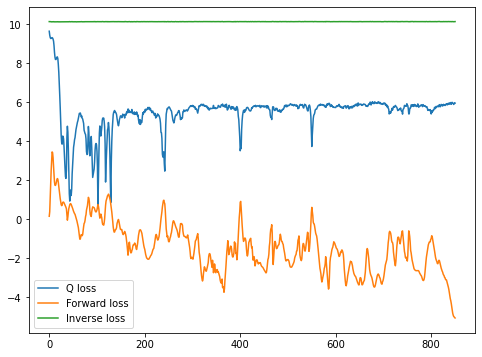

In [13]:
# 利用 env 套用 Qmodel 計算正確 action
# 再把資料給 env2 製作動畫

import gym
from nes_py.wrappers import JoypadSpace 
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT 
import matplotlib.pyplot as plt
from skimage.transform import resize #A
import numpy as np



env = gym_super_mario_bros.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="rgb_array") # 建立env1
env = JoypadSpace(env, COMPLEX_MOVEMENT)

env2 = gym_super_mario_bros.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")    # 建立env2
env2 = JoypadSpace(env2, COMPLEX_MOVEMENT)


eps=0.1
done = True
state_deque = deque(maxlen=params['frames_per_state'])
for step in range(10000):
    if done:
        
        env.reset()
        state1 = prepare_initial_state(env.render())
        env2.reset()
        
    q_val_pred = Qmodel(state1)
    action = int(policy(q_val_pred,eps))  
    state2, reward, terminated, truncated, info = env.step(action)                      
    done = terminated or truncated
    
    state2_2, reward_2, terminated_2, truncated_2, info_2 = env2.step(action)               # env2 利用 action
    
    
    
    
    state2 = prepare_multi_state(state1,state2)
    state1=state2
    

    
    
    #print(info_2)
    #print(info)
    #print(reward)
    #print(reward_2)
        
    if step == 5000:
        print(info_2['x_pos'])
    
    env2.render()
    
losses_ = np.array(losses)
plt.figure(figsize=(8,6))
plt.plot(np.log(losses_[:,0]),label='Q loss')
plt.plot(np.log(losses_[:,1]),label='Forward loss')
plt.plot(np.log(losses_[:,2]),label='Inverse loss')
plt.legend()
plt.show()
env.close()
env2.close()